Il presente Notebook illustra un esempio di Clustering Gerarchico, svolto mediante l'approccio dell'Agglomerative Clustering.

In [1]:
import sklearn
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
data_1722 = pd.read_csv("../../dataset/Train Set 1722.csv")
data_2223 = pd.read_csv("../../dataset/Test Set 2223.csv")
data_total = pd.concat([data_1722, data_2223], axis=0)

# Caricamento e Preparazione del Dataset

In base a quanto osservato nel Notebook "0 - Feature Selection", prepariamo il Dataset. Vengono eseguiti i seguenti step:

1. Feature Selection.
2. Rimozione di eventuali valori NaN.
3. Rimozione di tutti i Giocatori con meno di 5 Partite Giocate (almeno il 13.15% delle partite di un Campionato) o con meno di 343 Minuti Giocati (almeno il 10.03% dei minuti di un Campionato).

In [3]:
data_total = data_total[["Player", "Pos", "Squad", "Age", "Season", "Goals", "xG", "Shots on Target", "Shots", "Att Pen", "Offsides",
                  "GCA", "Carries into Penalty Area", "PK Attempted", "PK Made", "Att 3rd", "GCA TO to Goal", "Take-Ons Attempted", "Take-Ons Successful",
                  "GCA Shot to Goal", "Goals Scored while on Pitch", "Carries into Final 1/3", "xGS while on Pitch", "Matches Played", "G/Shots on Target",
                   "G/Shot", "Minutes", "Shots on Target%", "Shots on Target/90", "Shots/90", "Mid 3rd", "Def 3rd", "Def Pen"]]

data_total = data_total.dropna(how="any")
data_total = data_total[(data_total["Matches Played"] >= 5) & (data_total["Minutes"] >= 343)]

In [4]:
X_train = data_total[data_total["Season"] != 2223]
X_test = data_total[data_total["Season"] == 2223]

# Scaling del Dataset

Si ricordi che nel Clustering è buona norma scalare i Dati, poiché ogni Feature presa in considerazione ha un range di valori che può essere molto diverso dai range di valori delle altre.

In [5]:
X_train_to_scale = X_train[["xG", "Shots on Target", "Shots", "Att Pen", "Offsides",
                  "GCA", "Carries into Penalty Area", "PK Attempted", "PK Made", "Att 3rd", "GCA TO to Goal", "Take-Ons Attempted", "Take-Ons Successful",
                  "GCA Shot to Goal", "Goals Scored while on Pitch", "Carries into Final 1/3", "xGS while on Pitch", "Matches Played", "G/Shots on Target",
                   "G/Shot", "Minutes", "Shots on Target%", "Shots on Target/90", "Shots/90", "Mid 3rd", "Def 3rd", "Def Pen"]]

X_test_to_scale = X_test[["xG", "Shots on Target", "Shots", "Att Pen", "Offsides",
                  "GCA", "Carries into Penalty Area", "PK Attempted", "PK Made", "Att 3rd", "GCA TO to Goal", "Take-Ons Attempted", "Take-Ons Successful",
                  "GCA Shot to Goal", "Goals Scored while on Pitch", "Carries into Final 1/3", "xGS while on Pitch", "Matches Played", "G/Shots on Target",
                   "G/Shot", "Minutes", "Shots on Target%", "Shots on Target/90", "Shots/90", "Mid 3rd", "Def 3rd", "Def Pen"]]

Per effettuare la scalatura dei Dati utilizziamo lo *StandardScaler* di Scikit-Learn.

In [6]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

In [7]:
X_train_scaled = scaler.fit_transform(X_train_to_scale)
X_test_scaled = scaler.transform(X_test_to_scale)

# Riduzione di Dimensionalità

Un'altra buona pratica prevede la *Riduzione di Dimensionalità* dello Spazio delle Feature: questo sia per ridurre il tempo di computazione dell'addestramento del Modello di Clustering, sia per far sì che, rispetto allo Spazio delle Feature, i datapoint nello Spazio Ridotto siano in generale più vicini tra loro.

Un'ultimo vantaggio dell'applicazione della Riduzione di Dimensionalità prevede di ridurre ulteriormente la Correlazione Intrinseca tra le Feature stesse, che potrebbe viziare il processo di Clustering.

Per effettuare la Riduzione di Dimensionalità utilizziamo la tecnica di *Principal Component Analysis* (PCA), anch'essa implementata in Scikit-Learn. Si sceglie di effettuare la riduzione ma preservando il 95% del contenuto informativo.

In [8]:
from sklearn.decomposition import PCA
pca = PCA(n_components=0.95)

In [9]:
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

Osserviamo l'effetto della PCA sul Dataset:

In [10]:
print("Dimensioni del Training Set nello Spazio delle Feature: ", X_train_to_scale.shape)
print("Dimensioni del Training Set nello Spazio Ridotto: ", X_train_pca.shape)

print()

print("Dimensioni del Test Set nello Spazio delle Feature: ", X_test_to_scale.shape)
print("Dimensioni del Test Set nello Spazio Ridotto: ", X_test_pca.shape)

Dimensioni del Training Set nello Spazio delle Feature:  (10403, 27)
Dimensioni del Training Set nello Spazio Ridotto:  (10403, 12)

Dimensioni del Test Set nello Spazio delle Feature:  (2133, 27)
Dimensioni del Test Set nello Spazio Ridotto:  (2133, 12)


# AgglomerativeClustering

Si sceglie di osservare il comportamento di un Modello di Clustering basato sull'*AgglomerativeClustering*, disponibile in Scikit-Learn.

L'AgglomerativeClustering è un approccio *bottom-up* in cui inizialmente ogni datapoint è un Cluster a sè stante. Successivamente si "sale" nella gerarchia e i Cluster vengono fusi tra loro.

L'Algoritmo prevede i seguenti Step:
1. Inizialmente, ogni datapoint è un Cluster unitario.
2. Si prendono i due Cluster più vicini e si fondono, ottenendo un unico Cluster.
3. Si itera, eseguendo lo Step 2 fino a raggiungere il numero desiderato di Cluster.

In [11]:
from sklearn.cluster import AgglomerativeClustering

## Individuare il Numero Ottimale di Cluster

L'intero concetto di Clustering Gerarchico è legato alla costruzione e all'analisi di un Dendrogramma: la direzione verticale rappresenta la distanza tra i Cluster secondo la metrica scelta e muovendosi verso l'alto il numero di Cluster diminuisce.

Osservando il Dendrogramma completo non facciamo alcuna ipotesi sul numero di Cluster: possiamo identificare il numero ottimale sezionando orizzontalmente il Diagramma in un certo punto...quale? Quello tale da identificare il rettangolo orizzontale (base > altezza) tale da avere altezza massima e da non contenere al suo interno alcun segmento orizzontale.

In [12]:
import numpy as np
from scipy.cluster.hierarchy import dendrogram

In [13]:
def plot_dendrogram(model, **kwargs):
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count
        
    linkage_matrix = np.column_stack([model.children_, model.distances_, counts]).astype(float)
    
    dendrogram(linkage_matrix, **kwargs)

In [14]:
model = AgglomerativeClustering(distance_threshold=0, n_clusters=None)
model = model.fit(X_train_pca)

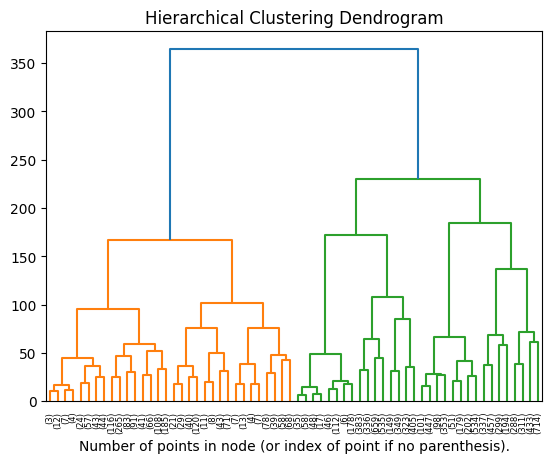

In [15]:
plt.title("Hierarchical Clustering Dendrogram")
plot_dendrogram(model, truncate_mode="level", p=5)
plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.show()

Effettuiamo la nostra scelta anche osservando il Silhouette Score, il Calinski-Harabasz Score e il Davies-Bouldin Score.

In [16]:
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score

In [17]:
silhouette_scores = []
ch_scores = []
db_scores = []
k_hypotheses = [2,3,4,5,6,7]

for k in k_hypotheses:
    model = AgglomerativeClustering(n_clusters=k)
    model.fit(X_train_pca)
    silhouette_scores.append(silhouette_score(X_train_pca, model.labels_))
    ch_scores.append(calinski_harabasz_score(X_train_pca, model.labels_))
    db_scores.append(davies_bouldin_score(X_train_pca, model.labels_))

### Silhouette Score

Il *Silhouette Score* misura la bontà di una tecnica di Clustering tenendo in considerazione per ogni punto:
- *a*: la distanza *intra-cluster* media, ovvero la distanza media del punto da tutti gli altri punti dello stesso Cluster.
- *b*: la distanza *inter-cluster* media, ovvero la distanza media del punto da tutti i punti del Cluster più vicino al punto considerato.

Silhouette Score per un punto:
$$
s_{Silhouette} = \displaystyle\frac{b-a}{max(a,b)}
$$

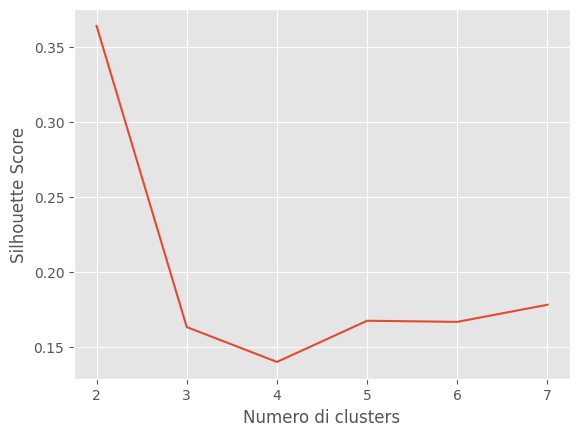

In [18]:
plt.figure()
plt.style.use("ggplot")
plt.plot(k_hypotheses, silhouette_scores)
plt.xticks(k_hypotheses)
plt.xlabel("Numero di clusters")
plt.ylabel("Silhouette Score")
plt.show()

In [19]:
print("Valori Silhouette Score:", silhouette_scores)

Valori Silhouette Score: [0.36373081333214624, 0.16301019848064313, 0.13979067472253817, 0.16723867752551952, 0.16648146575472664, 0.17790181922680434]


### Calinski-Harabasz Score

Calcola il rapporto tra la dispersione *inter-cluster* e la dispersione *intra-cluster* per ogni Cluster: maggiore è il punteggio, migliori sono le performance.

$$
s_{CH} = \displaystyle\frac{tr(B_k)}{tr(W_k)}\times\frac{n_E-k}{k-1}
$$

Dove:
- $n_E$ è la taglia del Dataset e $c_E$ è il suo centroide.
- $k$ è il Numero dei Cluster.
- $C_q$ è il Cluster q-esimo e $c_q$ è il suo centroide.
- $B_k = \displaystyle\sum_{q=1}^k\sum_{x\in C_q}(x-c_q)(x-c_q)^T$
- $W_k = \displaystyle\sum_{q=1}^kn_q(c_q-c_E)(c_q-c_E)^T$

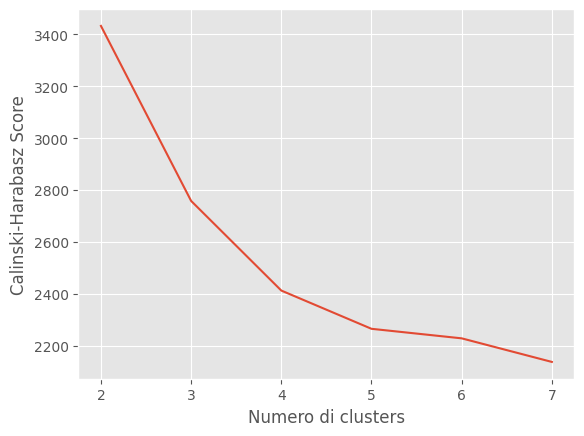

In [20]:
plt.figure()
plt.style.use("ggplot")
plt.plot(k_hypotheses, ch_scores)
plt.xticks(k_hypotheses)
plt.xlabel("Numero di clusters")
plt.ylabel("Calinski-Harabasz Score")
plt.show()

In [21]:
print("Valori Calinski-Harabasz Score:", ch_scores)

Valori Calinski-Harabasz Score: [3432.9745264154158, 2757.970469422921, 2412.2291795877054, 2264.7072054030086, 2227.9302838738345, 2136.979087803217]


### Davies-Bouldin Score

Il *Davies-Bouldin Score* indica la similarità media tra i Cluster, dove la similarità è una metrica che compara la distanza tra due Cluster con la loro cardinalità. Il valore minimo è $0$ e valori minori per questa metrica corrispondono a partizionamenti migliori del Dataset di partenza.

$$
s_{DB} = \displaystyle\frac{1}{k}\sum_{i=1}^kmax_{i\ne j}R_{ij} \implies R_{ij} = \frac{s_i + s_j}{d_{ij}}
$$

Dove:
- $s_i$ è il "diametro" del Cluster i-esimo, ovvero la distanza media tra ogni punto del Cluster e il centroide.
- $d_{ij}$ è la distanza tra i Cluster i-esimo e j-esimo, ovvero tra i loro centroidi.

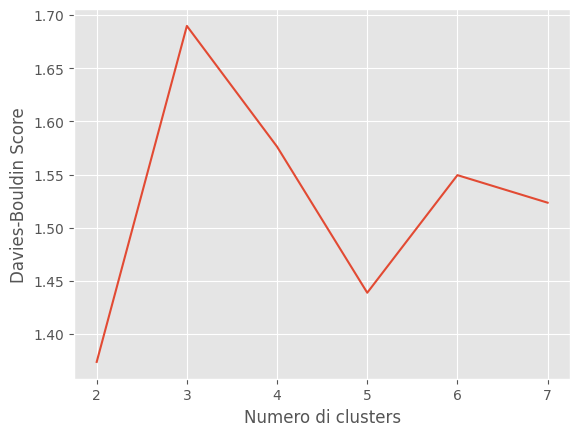

In [22]:
plt.figure()
plt.style.use("ggplot")
plt.plot(k_hypotheses, db_scores)
plt.xticks(k_hypotheses)
plt.xlabel("Numero di clusters")
plt.ylabel("Davies-Bouldin Score")
plt.show()

In [23]:
print("Valori Davies-Bouldin Score:", db_scores)

Valori Davies-Bouldin Score: [1.3736841654801222, 1.6897935320342015, 1.5761803067438225, 1.438779030045782, 1.5494101551105812, 1.5234915776995805]


Osserviamo come il valore $k=5$:
- Silhouette Score: $s_{Silhouette}$(5) ha il secondo valore massimo dopo $s_{Silhouette}(7), tolto però $s_{Silhouette}(2)$, che in realtà è poco rilevante.
- Calinski-Harabasz Score: $s_{CH}(5) > s_{CH}(7) > s_{CH}(6)$.
- Davies-Bouldin Score: $s_{DB}$(5) ha il valore minimo, tolto $s_{Silhouette}(2)$, che però è poco rilevante.

Si conclude, quindi, la ricerca del *k* ottimale, scegliendo di considerare 5 Cluster, nonostante il Rettangolo nel Dendrogramma sia piuttosto piccolo.

## Training del Modello

In [24]:
from datetime import datetime

In [25]:
model = AgglomerativeClustering(n_clusters=5)

In [26]:
start = datetime.now()
model.fit(X_train_pca)
end = datetime.now()
print("Total Time: " + str(end-start))

Total Time: 0:00:02.876119


In [27]:
train_labels = model.labels_

### Data Visualization del Training Set con t-SNE(3)

Per curiosità, osserviamo la disposizione del Training Set clusterizzato, in uno spazio 3D. Ciò è possibile grazie all'impiego della tecnica t-SNE, disponibile in Scikit-Learn.

Si osservi come si accetta di utilizzare il valore di *perplexity* standard, date le finalità di sola Data Visualization.

In [28]:
from sklearn.manifold import TSNE
import plotly.express as px

In [29]:
tsne = TSNE(3)

In [30]:
X_total = pd.concat([X_train, X_test], axis=0)
X_total_to_scale = X_total[["xG", "Shots on Target", "Shots", "Att Pen", "Offsides",
                  "GCA", "Carries into Penalty Area", "PK Attempted", "PK Made", "Att 3rd", "GCA TO to Goal", "Take-Ons Attempted", "Take-Ons Successful",
                  "GCA Shot to Goal", "Goals Scored while on Pitch", "Carries into Final 1/3", "xGS while on Pitch", "Matches Played", "G/Shots on Target",
                   "G/Shot", "Minutes", "Shots on Target%", "Shots on Target/90", "Shots/90", "Mid 3rd", "Def 3rd", "Def Pen"]]

In [31]:
X_total_tsne = tsne.fit_transform(X_total_to_scale)

In [32]:
X_train_tsne = X_total_tsne[X_total["Season"] != 2223]
X_test_tsne = X_total_tsne[X_total["Season"] == 2223]

In [33]:
X_train_tsne.shape

(10403, 3)

In [34]:
train_set_fig = px.scatter_3d(x=X_train_tsne[:, 0], y=X_train_tsne[:, 1], z=X_train_tsne[:, 2], color=train_labels)
train_set_fig.show()

### Cluster Report per il Training Set

La seguente sottosezione di blocchi di codice è funzionale a materializzare i Cluster ottenuti sul Training Set, qualora fosse necessario osservarli più nel dettaglio.

In [35]:
cluster0 = pd.DataFrame(columns=["Player", "Pos", "Squad", "Age", "Season", "Goals"])
cluster1 = pd.DataFrame(columns=["Player", "Pos", "Squad", "Age", "Season", "Goals"])
cluster2 = pd.DataFrame(columns=["Player", "Pos", "Squad", "Age", "Season", "Goals"])
cluster3 = pd.DataFrame(columns=["Player", "Pos", "Squad", "Age", "Season", "Goals"])
cluster4 = pd.DataFrame(columns=["Player", "Pos", "Squad", "Age", "Season", "Goals"])

In [36]:
players = X_train[["Player", "Pos", "Squad", "Age", "Season"]]

In [37]:
import warnings
warnings.filterwarnings('ignore')

for i in range(0, len(players)):
    label = train_labels[i]
    row = players.iloc[i].tolist()
    name = row[0]
    pos = row[1]
    squad = row[2]
    age = row[3]
    season = row[4]
    
    data = X_train.loc[(X_train["Player"] == name) & (X_train["Pos"] == pos) & (X_train["Squad"] == squad) & (X_train["Age"] == age) & (X_train["Season"] == season)]
    goals = int(data["Goals"])
    
    if label == 0: cluster0.loc[len(cluster0)] = [name, pos, squad, age, season, goals]
    if label == 1: cluster1.loc[len(cluster1)] = [name, pos, squad, age, season, goals]
    if label == 2: cluster2.loc[len(cluster2)] = [name, pos, squad, age, season, goals]
    if label == 3: cluster3.loc[len(cluster3)] = [name, pos, squad, age, season, goals]
    if label == 4: cluster4.loc[len(cluster4)] = [name, pos, squad, age, season, goals]

In [38]:
cluster0.describe()

Age       Season        Goals
count  1766.000000  1766.000000  1766.000000
mean     25.575878  1918.341450     7.319932
std       3.818498   143.693321     5.682648
min      16.000000  1718.000000     0.000000
25%      23.000000  1819.000000     3.000000
50%      25.000000  1920.000000     6.000000
75%      28.000000  2021.000000    10.000000
max      38.000000  2122.000000    41.000000

In [39]:
cluster1.describe()

Age       Season        Goals
count  3139.000000  3139.000000  3139.000000
mean     26.222364  1921.158331     0.997451
std       3.918903   143.964362     1.280582
min      16.000000  1718.000000     0.000000
25%      23.000000  1819.000000     0.000000
50%      26.000000  1920.000000     1.000000
75%      29.000000  2021.000000     2.000000
max      42.000000  2122.000000    10.000000

In [40]:
cluster2.describe()

Age       Season        Goals
count  3033.000000  3033.000000  3033.000000
mean     25.529179  1924.628750     2.583251
std       4.112199   141.707911     2.316001
min      15.000000  1718.000000     0.000000
25%      22.000000  1819.000000     1.000000
50%      25.000000  1920.000000     2.000000
75%      28.000000  2021.000000     3.000000
max      39.000000  2122.000000    18.000000

In [41]:
cluster3.describe()

Age       Season        Goals
count  1965.000000  1965.000000  1965.000000
mean     25.849873  1921.593384     0.008142
std       4.655041   144.938459     0.089891
min      15.000000  1718.000000     0.000000
25%      22.000000  1819.000000     0.000000
50%      26.000000  1920.000000     0.000000
75%      29.000000  2021.000000     0.000000
max      42.000000  2122.000000     1.000000

In [42]:
cluster4.describe()

Age       Season       Goals
count  500.000000   500.000000  500.000000
mean    28.108000  1918.586000    0.002000
std      4.129703   141.751026    0.044721
min     18.000000  1718.000000    0.000000
25%     25.000000  1819.000000    0.000000
50%     28.000000  1920.000000    0.000000
75%     31.000000  2021.000000    0.000000
max     40.000000  2122.000000    1.000000

In [43]:
# Esegui per materializzare i Cluster del Training Set
cluster0.to_excel("FILEPATH/cluster0.xlsx", index=False)
cluster1.to_excel("FILEPATH/cluster1.xlsx", index=False)
cluster2.to_excel("FILEPATH/cluster2.xlsx", index=False)
cluster3.to_excel("FILEPATH/cluster3.xlsx", index=False)
cluster4.to_excel("FILEPATH/cluster4.xlsx", index=False)

## Testing del Modello

Si fornisce ora il Test Set in input al Modello, con il fine di ottenere le predizioni.

In [44]:
def knn_predict(datapoint):
    neighbors = []
    for i in range(0, len(X_train_pca)):
        distance = np.linalg.norm(datapoint-X_train_pca[i], ord=2)
        neighbors.append((distance, train_labels[i]))
    
    neighbors.sort(key=lambda n: n[0])
    
    c0 = 0
    c1 = 0
    c2 = 0
    c3 = 0
    c4 = 0
    for i in range(0,100):
        if neighbors[i][1] == 0: c0 +=1
        if neighbors[i][1] == 1: c1 +=1
        if neighbors[i][1] == 2: c2 +=1
        if neighbors[i][1] == 3: c3 +=1
        if neighbors[i][1] == 4: c4 +=1
    
    label = max([c0, c1, c2, c3, c4])
    if label == c0: return 0
    if label == c1: return 1
    if label == c2: return 2
    if label == c3: return 3
    if label == c4: return 4

In [45]:
X_predicted = []
start = datetime.now()
for i in range(0, len(X_test_pca)):
    X_predicted.append(knn_predict(X_test_pca[i]))
end = datetime.now()
print(end-start)

0:01:24.150028


### Data Visualization del Test Set con t-SNE(3)

In [46]:
test_set_fig = px.scatter_3d(x=X_test_tsne[:, 0], y=X_test_tsne[:, 1], z=X_test_tsne[:, 2], color=X_predicted)
test_set_fig.show()

### Cluster Report per il Test Set

La seguente sottosezione di blocchi di codice è funzionale a materializzare i Cluster ottenuti sul Test Set, qualora fosse necessario osservarli più nel dettaglio.

In [47]:
cluster0test = pd.DataFrame(columns=["Player", "Pos", "Squad", "Age", "Season", "Goals"])
cluster1test = pd.DataFrame(columns=["Player", "Pos", "Squad", "Age", "Season", "Goals"])
cluster2test = pd.DataFrame(columns=["Player", "Pos", "Squad", "Age", "Season", "Goals"])
cluster3test = pd.DataFrame(columns=["Player", "Pos", "Squad", "Age", "Season", "Goals"])
cluster4test = pd.DataFrame(columns=["Player", "Pos", "Squad", "Age", "Season", "Goals"])

In [48]:
test_players = X_test[["Player", "Pos", "Squad", "Age", "Season"]]

In [49]:
import warnings
warnings.filterwarnings('ignore')

for i in range(0, len(test_players)):
    label = X_predicted[i]
    row = list(test_players.iloc[i])
    name = row[0]
    pos = row[1]
    squad = row[2]
    age = row[3]
    season = 2223
    
    data = X_test.loc[(X_test["Player"] == name) & (X_test["Pos"] == pos) & (X_test["Squad"] == squad) & (X_test["Age"] == age) & (X_test["Season"] == season)]
    goals = int(data["Goals"])
    
    if label == 0: cluster0test.loc[len(cluster0test)] = [name, pos, squad, age, season, goals]
    if label == 1: cluster1test.loc[len(cluster1test)] = [name, pos, squad, age, season, goals]
    if label == 2: cluster2test.loc[len(cluster2test)] = [name, pos, squad, age, season, goals]
    if label == 3: cluster3test.loc[len(cluster3test)] = [name, pos, squad, age, season, goals]
    if label == 4: cluster4test.loc[len(cluster4test)] = [name, pos, squad, age, season, goals]

In [50]:
cluster0test.describe()

Age  Season       Goals
count  296.000000   296.0  296.000000
mean    25.378378  2223.0    7.868243
std      3.817720     0.0    5.419945
min     17.000000  2223.0    0.000000
25%     22.000000  2223.0    4.000000
50%     25.000000  2223.0    6.000000
75%     28.000000  2223.0   10.000000
max     36.000000  2223.0   36.000000

In [51]:
cluster1test.describe()

Age  Season       Goals
count  701.000000   701.0  701.000000
mean    26.279601  2223.0    1.104137
std      3.918308     0.0    1.357202
min     17.000000  2223.0    0.000000
25%     24.000000  2223.0    0.000000
50%     26.000000  2223.0    1.000000
75%     29.000000  2223.0    2.000000
max     38.000000  2223.0    9.000000

In [52]:
cluster2test.describe()

Age  Season       Goals
count  635.000000   635.0  635.000000
mean    25.774803  2223.0    2.645669
std      4.338733     0.0    2.286732
min     16.000000  2223.0    0.000000
25%     22.000000  2223.0    1.000000
50%     25.000000  2223.0    2.000000
75%     29.000000  2223.0    4.000000
max     39.000000  2223.0   13.000000

In [53]:
cluster3test.describe()

Age  Season  Goals
count  395.000000   395.0  395.0
mean    25.615190  2223.0    0.0
std      4.554662     0.0    0.0
min     16.000000  2223.0    0.0
25%     22.000000  2223.0    0.0
50%     25.000000  2223.0    0.0
75%     29.000000  2223.0    0.0
max     41.000000  2223.0    0.0

In [54]:
cluster4test.describe()

Age  Season  Goals
count  106.000000   106.0  106.0
mean    29.000000  2223.0    0.0
std      4.082483     0.0    0.0
min     20.000000  2223.0    0.0
25%     26.000000  2223.0    0.0
50%     29.000000  2223.0    0.0
75%     31.000000  2223.0    0.0
max     39.000000  2223.0    0.0

In [55]:
# Esegui per materializzare i Cluster del Test Set
cluster0test.to_excel("FILEPATH/cluster0test.xlsx", index=False)
cluster1test.to_excel("FILEPATH/cluster1test.xlsx", index=False)
cluster2test.to_excel("FILEPATH/cluster2test.xlsx", index=False)
cluster3test.to_excel("FILEPATH/cluster3test.xlsx", index=False)
cluster4test.to_excel("FILEPATH/cluster4test.xlsx", index=False)